In [ ]:
# Install required packages
!pip install tensorflow pandas numpy matplotlib opencv-python scikit-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback


In [ ]:
# Download and unzip GTSRB dataset
!wget -q https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Training_Images.zip

# Download class names
!wget -q https://raw.githubusercontent.com/prajnasb/observations/master/experiements/data/GTSRB/signnames.csv


In [ ]:
IMG_SIZE = 48
NUM_CLASSES = 43

def load_data(data_dir):
    images = []
    labels = []
    for class_id in range(NUM_CLASSES):
        class_path = os.path.join(data_dir, format(class_id, '05d'))
        for img_name in os.listdir(class_path):
            if img_name.endswith('.ppm'):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(class_id)
    return np.array(images), np.array(labels)

X, y = load_data('GTSRB/Final_Training/Images')

X = X / 255.0
y_cat = to_categorical(y, NUM_CLASSES)

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (31367, 48, 48, 3), Validation shape: (7842, 48, 48, 3)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)


In [ ]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,593,963 (21.34 MB)

 Trainable params: 5,592,555 (21.33 MB)

 Non-trainable params: 1,408 (5.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4200 - loss: 2.2829


Epoch 1 summary:
Train loss: 1.3250 | Val loss: 0.7068
Train acc: 0.6322 | Val acc: 0.8111
491/491 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.4204 - loss: 2.2810 - val_accuracy: 0.8111 - val_loss: 0.7068
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9001 - loss: 0.3336


Epoch 2 summary:
Train loss: 0.2745 | Val loss: 0.0393
Train acc: 0.9180 | Val acc: 0.9920
491/491 ━━━━━━━━━━━━━━━━━━━━ 65s 63ms/step - accuracy: 0.9002 - loss: 0.3335 - val_accuracy: 0.9920 - val_loss: 0.0393
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9545 - loss: 0.1496


Epoch 3 summary:
Train loss: 0.1326 | Val loss: 0.0160
Train acc: 0.9598 | Val acc: 0.9949
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.9545 - loss: 0.1496 - val_accuracy: 0.9949 - val_loss: 0.0160
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9750 - loss: 0.0870
Epoch 4 summary:
Train loss: 0.0898 | Val loss: 0.0190
Train acc: 0.9735 | Val acc: 0.9939
491/491 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.9750 - loss: 0.0870 - val_accuracy: 0.9939 - val_loss: 0.0190
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9797 - loss: 0.0734


Epoch 5 summary:
Train loss: 0.0730 | Val loss: 0.0068
Train acc: 0.9793 | Val acc: 0.9981
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.9797 - loss: 0.0734 - val_accuracy: 0.9981 - val_loss: 0.0068
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9813 - loss: 0.0640
Epoch 6 summary:
Train loss: 0.0648 | Val loss: 0.0660
Train acc: 0.9806 | Val acc: 0.9772
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.9813 - loss: 0.0640 - val_accuracy: 0.9772 - val_loss: 0.0660
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9823 - loss: 0.0571
Epoch 7 summary:
Train loss: 0.0550 | Val loss: 0.0069
Train acc: 0.9827 | Val acc: 0.9977
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.9823 - loss: 0.0571 - val_accuracy: 0.9977 - val_loss: 0.0069
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9862 - loss: 0.0442


Epoch 8 summary:
Train loss: 0.0442 | Val loss: 0.0063
Train acc: 0.9864 | Val acc: 0.9983
491/491 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.9862 - loss: 0.0442 - val_accuracy: 0.9983 - val_loss: 0.0063
Epoch 9/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9875 - loss: 0.0398


Epoch 9 summary:
Train loss: 0.0440 | Val loss: 0.0045
Train acc: 0.9864 | Val acc: 0.9982
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.9875 - loss: 0.0398 - val_accuracy: 0.9982 - val_loss: 0.0045
Epoch 10/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9868 - loss: 0.0427
Epoch 10 summary:
Train loss: 0.0439 | Val loss: 0.2158
Train acc: 0.9861 | Val acc: 0.9398
491/491 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.9868 - loss: 0.0427 - val_accuracy: 0.9398 - val_loss: 0.2158
Epoch 11/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9860 - loss: 0.0422


Epoch 11 summary:
Train loss: 0.0376 | Val loss: 0.0029
Train acc: 0.9883 | Val acc: 0.9986
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.9860 - loss: 0.0422 - val_accuracy: 0.9986 - val_loss: 0.0029
Epoch 12/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9918 - loss: 0.0287


Epoch 12 summary:
Train loss: 0.0326 | Val loss: 0.0025
Train acc: 0.9903 | Val acc: 0.9995
491/491 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.9918 - loss: 0.0287 - val_accuracy: 0.9995 - val_loss: 0.0025
Epoch 13/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9895 - loss: 0.0362
Epoch 13 summary:
Train loss: 0.0334 | Val loss: 0.0062
Train acc: 0.9900 | Val acc: 0.9978
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.9895 - loss: 0.0362 - val_accuracy: 0.9978 - val_loss: 0.0062
Epoch 14/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9912 - loss: 0.0298
Epoch 14 summary:
Train loss: 0.0332 | Val loss: 0.0029
Train acc: 0.9901 | Val acc: 0.9991
491/491 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.9912 - loss: 0.0298 - val_accuracy: 0.9991 - val_loss: 0.0029
Epoch 15/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9898 - loss: 0.0323
Epoch 15 summary:
Train loss: 0.0324 | Val loss: 0.0037
Train acc: 0.9899 | Val acc: 0.9986
491/491 ━━

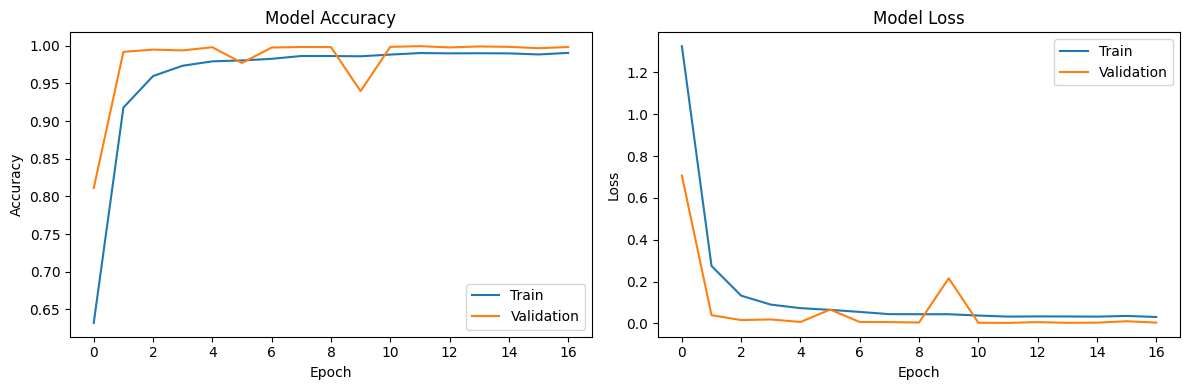

In [ ]:
def epoch_end(epoch, logs):
    print(f"\nEpoch {epoch+1} summary:")
    print(f"Train loss: {logs['loss']:.4f} | Val loss: {logs['val_loss']:.4f}")
    print(f"Train acc: {logs['accuracy']:.4f} | Val acc: {logs['val_accuracy']:.4f}")

epoch_update = LambdaCallback(on_epoch_end=epoch_end)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, epoch_update],
    verbose=1
)

def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training(history)


In [ ]:
print("\nStarting evaluation...")
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print(f'\nValidation accuracy: {val_acc:.4f}')



Starting evaluation...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0024

Validation accuracy: 0.9995


In [ ]:
from google.colab import files
uploaded = files.upload()  # Select signnames.csv from your computer


Saving signnames.csv to signnames.csv


In [ ]:
sign_names = pd.read_csv('signnames.csv')

def predict_sign(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    normalized = img / 255.0
    expanded = np.expand_dims(normalized, axis=0)
    pred = model.predict(expanded)
    class_id = np.argmax(pred)
    confidence = np.max(pred)
    sign_name = sign_names[sign_names['ClassId'] == class_id]['SignName'].values[0]
    plt.imshow(img)
    plt.title(f"Predicted: {sign_name}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()
    return class_id, sign_name, confidence

# Example usage:
# predict_sign('GTSRB/Final_Training/Images/00000/00000_00000.ppm')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/traffic_sign_model.h5')


In [ ]:
model.save('/content/drive/MyDrive/traffic_sign_model.keras')


#upload image and detect it , test code

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/traffic_sign_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from google.colab import files

# This will prompt you to select a file from your computer
uploaded = files.upload()

# Get the filename (first key in the uploaded dict)
image_path = next(iter(uploaded))
print(f"Uploaded file: {image_path}")


Saving test8.png to test8.png
Uploaded file: test8.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step


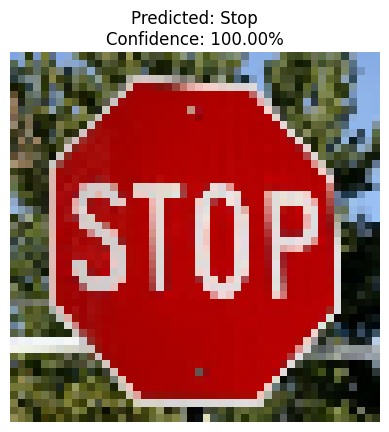

Prediction: Stop (Class 14) with confidence 100.00%


In [ ]:
# Use the predict_sign function defined earlier
# (Make sure your model and predict_sign function are already loaded in memory)

class_id, sign_name, confidence = predict_sign(image_path)
print(f"Prediction: {sign_name} (Class {class_id}) with confidence {confidence:.2%}")


In [ ]:
# defined classes for reference:
# ClassId	SignName
# 0	Speed limit (20km/h)
# 1	Speed limit (30km/h)
# 2	Speed limit (50km/h)
# 3	Speed limit (60km/h)
# 4	Speed limit (70km/h)
# 5	Speed limit (80km/h)
# 6	End of speed limit (80km/h)
# 7	Speed limit (100km/h)
# 8	Speed limit (120km/h)
# 9	No passing
# 10	No passing for vechiles over 3.5 metric tons
# 11	Right-of-way at the next intersection
# 12	Priority road
# 13	Yield
# 14	Stop
# 15	No vechiles
# 16	Vechiles over 3.5 metric tons prohibited
# 17	No entry
# 18	General caution
# 19	Dangerous curve to the left
# 20	Dangerous curve to the right
# 21	Double curve
# 22	Bumpy road
# 23	Slippery road
# 24	Road narrows on the right
# 25	Road work
# 26	Traffic signals
# 27	Pedestrians
# 28	Children crossing
# 29	Bicycles crossing
# 30	Beware of ice/snow
# 31	Wild animals crossing
# 32	End of all speed and passing limits
# 33	Turn right ahead
# 34	Turn left ahead
# 35	Ahead only
# 36	Go straight or right
# 37	Go straight or left
# 38	Keep right
# 39	Keep left
# 40	Roundabout mandatory
# 41	End of no passing
# 42	End of no passing by vechiles over 3.5 metric tons

In [ ]:
from google.colab import files

# This will prompt you to select a file from your computer
uploaded = files.upload()

# Get the filename (first key in the uploaded dict)
image_path = next(iter(uploaded))
print(f"Uploaded file: {image_path}")


Saving Screenshot 2025-04-23 050326.png to Screenshot 2025-04-23 050326.png
Uploaded file: Screenshot 2025-04-23 050326.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


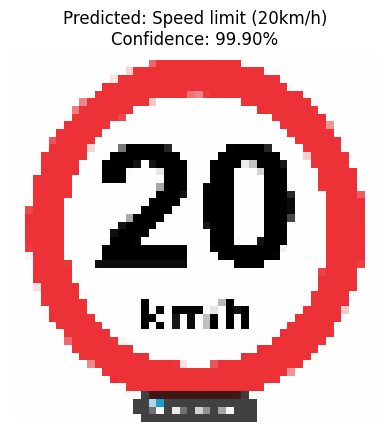

Prediction: Speed limit (20km/h) (Class 0) with confidence 99.90%


In [ ]:
# Use the predict_sign function defined earlier
# (Make sure your model and predict_sign function are already loaded in memory)

class_id, sign_name, confidence = predict_sign(image_path)
print(f"Prediction: {sign_name} (Class {class_id}) with confidence {confidence:.2%}")


In [ ]:
from google.colab import files

# This will prompt you to select a file from your computer
uploaded = files.upload()

# Get the filename (first key in the uploaded dict)
image_path = next(iter(uploaded))
print(f"Uploaded file: {image_path}")


Saving test1.png to test1.png
Uploaded file: test1.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


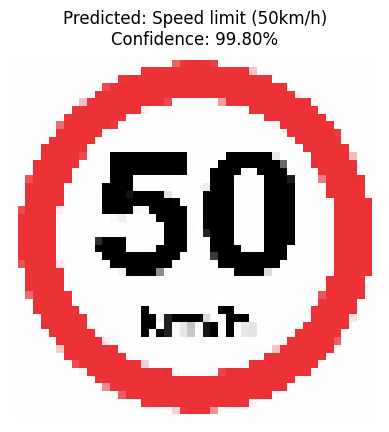

Prediction: Speed limit (50km/h) (Class 2) with confidence 99.80%


In [ ]:
# Use the predict_sign function defined earlier
# (Make sure your model and predict_sign function are already loaded in memory)

class_id, sign_name, confidence = predict_sign(image_path)
print(f"Prediction: {sign_name} (Class {class_id}) with confidence {confidence:.2%}")


In [ ]:
from google.colab import files

# This will prompt you to select a file from your computer
uploaded = files.upload()

# Get the filename (first key in the uploaded dict)
image_path = next(iter(uploaded))
print(f"Uploaded file: {image_path}")


Saving Screenshot 2025-04-23 095411.png to Screenshot 2025-04-23 095411.png
Uploaded file: Screenshot 2025-04-23 095411.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


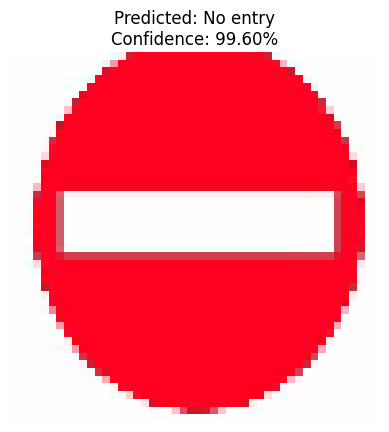

Prediction: No entry (Class 17) with confidence 99.60%


In [ ]:
# Use the predict_sign function defined earlier
# (Make sure your model and predict_sign function are already loaded in memory)

class_id, sign_name, confidence = predict_sign(image_path)
print(f"Prediction: {sign_name} (Class {class_id}) with confidence {confidence:.2%}")


In [ ]:
from google.colab import files

# This will prompt you to select a file from your computer
uploaded = files.upload()

# Get the filename (first key in the uploaded dict)
image_path = next(iter(uploaded))
print(f"Uploaded file: {image_path}")


Saving WhatsApp Image 2025-04-23 at 10.02.27 AM.jpeg to WhatsApp Image 2025-04-23 at 10.02.27 AM.jpeg
Uploaded file: WhatsApp Image 2025-04-23 at 10.02.27 AM.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


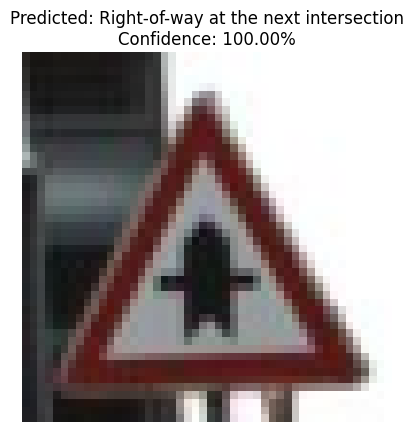

Prediction: Right-of-way at the next intersection (Class 11) with confidence 100.00%


In [ ]:
# Use the predict_sign function defined earlier
# (Make sure your model and predict_sign function are already loaded in memory)

class_id, sign_name, confidence = predict_sign(image_path)
print(f"Prediction: {sign_name} (Class {class_id}) with confidence {confidence:.2%}")
